In [1]:
import xpress as xp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyreadr import read_r
from scipy.interpolate import interp1d
from param_watervalues import Reservoir
from time import time
import seaborn as sns

In [2]:
%load_ext line_profiler

In [3]:
%matplotlib widget

In [4]:
# xp.controls.outputlog = 0
xp.controls.threads = 1
xp.controls.scaling = 0
xp.controls.presolve = 0
xp.controls.feastol = 1.e-7
xp.controls.optimalitytol = 1.e-7
# xp.setOutputEnabled(False)

In [70]:
study_path = "D:/Users/gerbauxjul/Documents/6-Etudes Antares/20240624_1447_ERAA24_TY_2028_AGG_hydromc_bug"
output_path = study_path+"/output/20240731-1634eco-exportmps_8_8_corr"

In [71]:
def retrieve_problem(year,week,output_path,itr=1):
    model = xp.problem()
    model.read(output_path+f"/problem-{year}-{week}--optim-nb-{itr}.mps")
    return(model)

def modify_objective(model, u):
    cst = model.getConstraint()
    binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]
    model.chgrhs(binding_id,[u])
    return(model)

def milp_version(model):
    vars = model.getVariable()
    interger_vars = [i for i in range(len(vars)) if vars[i].name.strip().split("::")[0] in ['NODU', 'NumberBreakingDownDispatchableUnits', 'NumberStartingDispatchableUnits','NumberStoppingDispatchableUnits']]
    for i in interger_vars:
        model.chgcoltype([vars[i]],'I')
    return(model)

In [72]:
m = retrieve_problem(7,13,output_path,itr=1)

Reading Problem Pb Solve
Problem Statistics
        1532 (      1 spare) rows
        6216 (      0 spare) structural columns
       12935 (   6048 spare) non-zero elements
Global Statistics
           0 entities        0 sets        0 set members



In [73]:
vars = m.getVariable()
len(vars)

6216

In [74]:
cons = m.getConstraint()
len(cons)

1532

In [75]:
m.solve()

FICO Xpress v8.14.8, Hyper, solve started 17:44:35, Jul 31, 2024
Heap usage: 2034KB (peak 2034KB, 964KB system)
Minimizing LP Pb Solve using 1 thread and up to 31GB memory, with these control settings:
SCALING = 0
PRESOLVE = 0
OUTPUTLOG = 1
THREADS = 1
FEASTOL = 1.e-7
OPTIMALITYTOL = 1.e-7
Original problem has:
      1532 rows         6216 cols        12935 elements

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 7.50e-01,  1.00e+00] / [ 7.50e-01,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e-05,  1.00e+06] / [ 1.00e-05,  1.00e+06]
  Objective      [min,max] : [ 5.01e-04,  2.00e+04] / [ 5.01e-04,  2.00e+04]

Crash basis containing 450 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       80986487.02      D      1   168        .084269     0
   830       108127739.9      D     61     0        .000000     0
Problem is infeasible


In [76]:
df_vars = pd.DataFrame(vars, columns=["names"])
df_vars["split"] = df_vars["names"].apply(lambda x:x.name.strip().split("::"))
df_vars["name_var"] = df_vars["split"].apply(lambda x:x[0])
df_vars["antares_object"] = df_vars["split"].apply(lambda x:x[1].split("<")[0])
df_vars["name_antares_object"] = df_vars["split"].apply(lambda x:x[1].split("<")[1].split(">")[0])
df_vars["subobject"] = df_vars["split"].apply(lambda x:x[2] if len(x)>=4 else "None")
df_vars["time"] = df_vars["split"].apply(lambda x:int(x[-1].split("<")[1].split(">")[0]))
df_vars["time_type"] = df_vars["split"].apply(lambda x:x[-1].split("<")[0])
coltype = []
m.getcoltype(coltype, 0, m.attributes.cols - 1)
df_vars['coltype'] = coltype
bounds = []
m.getlb(bounds, 0, m.attributes.cols - 1)
df_vars['lb'] = bounds
bounds = []
m.getub(bounds, 0, m.attributes.cols - 1)
df_vars['ub'] = bounds
objcoef = []
m.getobj(objcoef,0,m.attributes.cols-1)
df_vars= df_vars.assign(coeff=[objcoef[i] for i in range(m.attributes.cols)])
df_vars = df_vars.assign(sol=[m.getSolution(i) for i in range(m.attributes.cols)])
# df_vars = df_vars.assign(obj = lambda x: np.round(df_vars['sol'],6)*np.round(df_vars['coeff'],6))

In [77]:
df_vars

,names,split,name_var,antares_object,name_antares_object,subobject,time,time_type,coltype,lb,ub,coeff,sol
0,NTCDirect::link<2_cz00_hydro_open$$cz00>::hour...,"[NTCDirect, link<2_cz00_hydro_open$$cz00>, hou...",NTCDirect,link,2_cz00_hydro_open$$cz00,None,2016,hour,C,-599.000000,2.040000e+02,0.000000,0.0
1,NTCDirect::link<3_es00_hydro_res$$es00>::hour<...,"[NTCDirect, link<3_es00_hydro_res$$es00>, hour...",NTCDirect,link,3_es00_hydro_res$$es00,None,2016,hour,C,0.000000,1.000000e+06,0.000000,0.0
2,PositiveUnsuppliedEnergy::area<2_cz00_hydro_op...,"[PositiveUnsuppliedEnergy, area<2_cz00_hydro_o...",PositiveUnsuppliedEnergy,area,2_cz00_hydro_open,None,2016,hour,C,0.000000,1.000000e-05,-0.000502,0.0
3,NegativeUnsuppliedEnergy::area<2_cz00_hydro_op...,"[NegativeUnsuppliedEnergy, area<2_cz00_hydro_o...",NegativeUnsuppliedEnergy,area,2_cz00_hydro_open,None,2016,hour,C,0.000000,1.000000e+20,-0.000502,0.0
4,PositiveUnsuppliedEnergy::area<3_es00_hydro_re...,"[PositiveUnsuppliedEnergy, area<3_es00_hydro_r...",PositiveUnsuppliedEnergy,area,3_es00_hydro_res,None,2016,hour,C,0.000000,1.000000e-05,0.000515,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6211,Pumping::area<2_cz00_hydro_open>::hour<2183> ...,"[Pumping, area<2_cz00_hydro_open>, hour<2183>]",Pumping,area,2_cz00_hydro_open,None,2183,hour,C,0.000000,5.990000e+02,0.001810,0.0
6212,HydroLevel::area<2_cz00_hydro_open>::hour<2183...,"[HydroLevel, area<2_cz00_hydro_open>, hour<2183>]",HydroLevel,area,2_cz00_hydro_open,None,2183,hour,C,0.000000,2.945000e+03,0.000000,0.0
6213,Overflow::area<2_cz00_hydro_open>::hour<2183> ...,"[Overflow, area<2_cz00_hydro_open>, hour<2183>]",Overflow,area,2_cz00_hydro_open,None,2183,hour,C,0.000000,5.083333e+00,-0.000502,0.0
6214,HydProd::area<3_es00_hydro_res>::hour<2183> ...,"[HydProd, area<3_es00_hydro_res>, hour<2183>]",HydProd,area,3_es00_hydro_res,None,2183,hour,C,324.280303,1.547000e+03,0.000507,0.0


In [78]:
df_vars["name_var"].unique()

array(['NTCDirect', 'PositiveUnsuppliedEnergy',
       'NegativeUnsuppliedEnergy', 'DispatchableProduction', 'HydProd',
       'Pumping', 'HydroLevel', 'Overflow'], dtype=object)

In [51]:
df_vars.loc[(df_vars["name_var"].isin(['HydroLevel']))]

,names,split,name_var,antares_object,name_antares_object,subobject,time,time_type,coltype,lb,ub,coeff,sol
33,HydroLevel::area<2_cz00_hydro_open>::hour<2184...,"[HydroLevel, area<2_cz00_hydro_open>, hour<2184>]",HydroLevel,area,2_cz00_hydro_open,None,2184,hour,C,0.0,2945.0,0.0,1597.694499
70,HydroLevel::area<2_cz00_hydro_open>::hour<2185...,"[HydroLevel, area<2_cz00_hydro_open>, hour<2185>]",HydroLevel,area,2_cz00_hydro_open,None,2185,hour,C,0.0,2945.0,0.0,1597.694499
107,HydroLevel::area<2_cz00_hydro_open>::hour<2186...,"[HydroLevel, area<2_cz00_hydro_open>, hour<2186>]",HydroLevel,area,2_cz00_hydro_open,None,2186,hour,C,0.0,2945.0,0.0,1597.694499
144,HydroLevel::area<2_cz00_hydro_open>::hour<2187...,"[HydroLevel, area<2_cz00_hydro_open>, hour<2187>]",HydroLevel,area,2_cz00_hydro_open,None,2187,hour,C,0.0,2945.0,0.0,1602.569499
181,HydroLevel::area<2_cz00_hydro_open>::hour<2188...,"[HydroLevel, area<2_cz00_hydro_open>, hour<2188>]",HydroLevel,area,2_cz00_hydro_open,None,2188,hour,C,0.0,2945.0,0.0,1607.444499
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6064,HydroLevel::area<2_cz00_hydro_open>::hour<2347...,"[HydroLevel, area<2_cz00_hydro_open>, hour<2347>]",HydroLevel,area,2_cz00_hydro_open,None,2347,hour,C,0.0,2945.0,0.0,1834.836389
6101,HydroLevel::area<2_cz00_hydro_open>::hour<2348...,"[HydroLevel, area<2_cz00_hydro_open>, hour<2348>]",HydroLevel,area,2_cz00_hydro_open,None,2348,hour,C,0.0,2945.0,0.0,1839.711389
6138,HydroLevel::area<2_cz00_hydro_open>::hour<2349...,"[HydroLevel, area<2_cz00_hydro_open>, hour<2349>]",HydroLevel,area,2_cz00_hydro_open,None,2349,hour,C,0.0,2945.0,0.0,1844.586389
6175,HydroLevel::area<2_cz00_hydro_open>::hour<2350...,"[HydroLevel, area<2_cz00_hydro_open>, hour<2350>]",HydroLevel,area,2_cz00_hydro_open,None,2350,hour,C,0.0,2945.0,0.0,1849.461389


In [52]:
cap =2945

In [53]:
1597.694499/cap

0.5425108655348048

In [32]:
fin_level_8_8 = 1070.791819

In [54]:
df_cons = pd.DataFrame(cons, columns=["names"])
df_cons["split"] = df_cons["names"].apply(lambda x:x.name.strip().split("::"))
df_cons["name_cons"] = df_cons["split"].apply(lambda x:x[0])
df_cons["antares_object"] = df_cons["split"].apply(lambda x:x[1].split("<")[0])
df_cons["name_antares_object"] = df_cons["split"].apply(lambda x:x[1].split("<")[1].split(">")[0] if len(x[1].split("<"))>=2 else "None")
df_cons["time"] = df_cons["split"].apply(lambda x:int(x[-1].split("<")[1].split(">")[0]))
df_cons["time_type"] = df_cons["split"].apply(lambda x:x[-1].split("<")[0])
rhs = []
m.getrhs(rhs, 0, m.attributes.rows - 1)
df_cons["rhs"] = rhs

In [55]:
df_cons

,names,split,name_cons,antares_object,name_antares_object,time,time_type,rhs
0,AreaBalance::area<2_cz00_hydro_open>::hour<218...,"[AreaBalance, area<2_cz00_hydro_open>, hour<21...",AreaBalance,area,2_cz00_hydro_open,2184,hour,0.000
1,FictiveLoads::area<2_cz00_hydro_open>::hour<21...,"[FictiveLoads, area<2_cz00_hydro_open>, hour<2...",FictiveLoads,area,2_cz00_hydro_open,2184,hour,0.000
2,AreaBalance::area<3_es00_hydro_res>::hour<2184...,"[AreaBalance, area<3_es00_hydro_res>, hour<2184>]",AreaBalance,area,3_es00_hydro_res,2184,hour,0.000
3,FictiveLoads::area<3_es00_hydro_res>::hour<218...,"[FictiveLoads, area<3_es00_hydro_res>, hour<21...",FictiveLoads,area,3_es00_hydro_res,2184,hour,0.000
4,AreaBalance::area<cz00>::hour<2184> ...,"[AreaBalance, area<cz00>, hour<2184>]",AreaBalance,area,cz00,2184,hour,-5807.200
...,...,...,...,...,...,...,...,...
1527,AreaHydroLevel::area<2_cz00_hydro_open>::hour<...,"[AreaHydroLevel, area<2_cz00_hydro_open>, hour...",AreaHydroLevel,area,2_cz00_hydro_open,2347,hour,4.875
1528,AreaHydroLevel::area<2_cz00_hydro_open>::hour<...,"[AreaHydroLevel, area<2_cz00_hydro_open>, hour...",AreaHydroLevel,area,2_cz00_hydro_open,2348,hour,4.875
1529,AreaHydroLevel::area<2_cz00_hydro_open>::hour<...,"[AreaHydroLevel, area<2_cz00_hydro_open>, hour...",AreaHydroLevel,area,2_cz00_hydro_open,2349,hour,4.875
1530,AreaHydroLevel::area<2_cz00_hydro_open>::hour<...,"[AreaHydroLevel, area<2_cz00_hydro_open>, hour...",AreaHydroLevel,area,2_cz00_hydro_open,2350,hour,4.875


In [56]:
df_cons["name_cons"].unique()

array(['AreaBalance', 'FictiveLoads', 'BC_cz00_dsr_pb_500',
       'BC_es00_dsr_pb_20000', 'HydroPower', 'MinHydroPower',
       'MaxHydroPower', 'MaxPumping', 'AreaHydroLevel'], dtype=object)

In [79]:
m.write("problem","l")

In [57]:
df_cons[(df_cons.name_cons=='HydroPower')&(df_cons.name_antares_object=='2_cz00_hydro_open')]

,names,split,name_cons,antares_object,name_antares_object,time,time_type,rhs
1358,HydroPower::area<2_cz00_hydro_open>::week<13> ...,"[HydroPower, area<2_cz00_hydro_open>, week<13>]",HydroPower,area,2_cz00_hydro_open,13,week,557.48311


In [58]:
df_cons[(df_cons.name_cons=='AreaHydroLevel')&(df_cons.name_antares_object=='2_cz00_hydro_open')].head(2)

,names,split,name_cons,antares_object,name_antares_object,time,time_type,rhs
1364,AreaHydroLevel::area<2_cz00_hydro_open>::hour<...,"[AreaHydroLevel, area<2_cz00_hydro_open>, hour...",AreaHydroLevel,area,2_cz00_hydro_open,2184,hour,1597.694499
1365,AreaHydroLevel::area<2_cz00_hydro_open>::hour<...,"[AreaHydroLevel, area<2_cz00_hydro_open>, hour...",AreaHydroLevel,area,2_cz00_hydro_open,2185,hour,4.875000


In [20]:
4.875000*168

819.0

In [21]:
(1597.694499-4.875000)/2945*100

54.08555174872666

In [59]:
sum(df_vars.loc[df_vars.name_var.isin(['HydProd','Overflow'])&(df_vars.name_antares_object=='2_cz00_hydro_open'),"sol"])

557.483110317

In [61]:
sum(df_vars.loc[df_vars.name_var.isin(['HydProd'])&(df_vars.name_antares_object=='2_cz00_hydro_open'),"sol"])

11.806498677999635

In [62]:
sum(df_vars.loc[df_vars.name_var.isin(['Overflow'])&(df_vars.name_antares_object=='2_cz00_hydro_open'),"sol"])

545.6766116390004

In [60]:
(1597.694499+4.875000*168-sum(df_vars.loc[df_vars.name_var.isin(['HydProd'])&(df_vars.name_antares_object=='2_cz00_hydro_open'),"sol"]))/2945*100

81.66003396679119

In [66]:
# Semaine 22
2949.291666667+721-590> 2945

True

In [81]:
# Année 7, semaine 13,v_8_8
66.617505359+854-947.93372<0

True

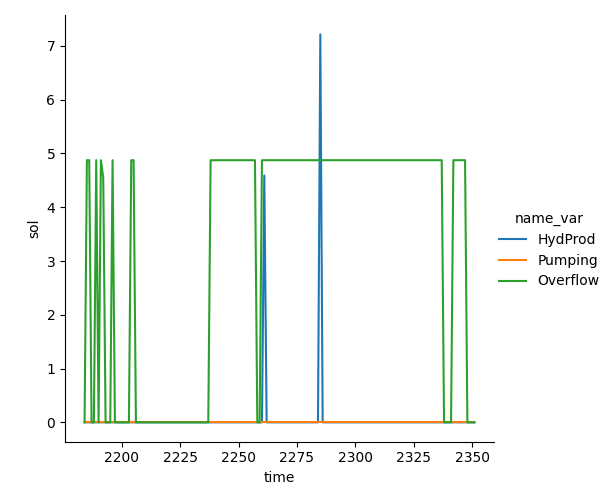

In [23]:
sns.relplot(x="time",y="sol",data=df_vars.loc[df_vars.name_var.isin(['HydProd',
       'Pumping', 'Overflow'])&(df_vars.name_antares_object=='2_cz00_hydro_open')],hue="name_var",kind="line")

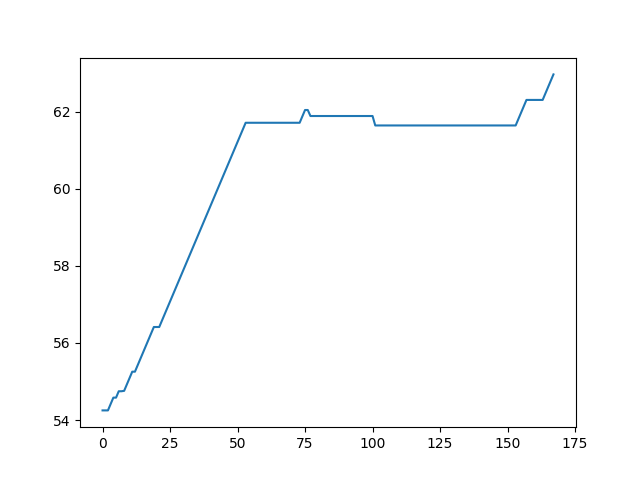

In [24]:
plt.figure()
plt.plot(df_vars.loc[df_vars.name_var.isin(['HydroLevel'])&(df_vars.name_antares_object=='2_cz00_hydro_open'),"sol"].values/2945*100)